# Lab 5: 

Lab session by:
* Daniel Hess
* Pandelis Laurens Symeonidis

# Imports and setup

In [2]:
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('wordnet_ic')

from nltk.corpus import wordnet_ic, wordnet as wn
from itertools import combinations, product
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     /Users/pandelissymeonidis/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


### Penn tag to Wordnet mapping

In [3]:
def convert_category(word: str, penn_tag: str):
    d = {'NN': 'n', 'NNS': 'n',
          'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
            'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 
            'RB': 'r', 'RBR': 'r', 'RBS': 'r'} 
    
    if penn_tag in d: 
        return word, d[penn_tag]
    else:
        return word, None 

### Convert penn -> wordnet (POS)

In [4]:
pairs_penn = [('the','DT'), ('man','NN'), ('swim','VB'), ('with', 'PR'), ('a', 'DT'),
('girl','NN'), ('and', 'CC'), ('a', 'DT'), ('boy', 'NN'), ('whilst', 'PR'),
('the', 'DT'), ('woman', 'NN'), ('walk', 'VB')]

converted = [convert_category(w, t) for w, t in pairs_penn]
pairs_wn = [pair for pair in converted if pair[1]] # If pos = None, it is not indexed by wordnet
print(pairs_wn)

synsets = [wn.synsets(lemma=w, pos=t)[0] for w, t in pairs_wn] # Compute most frequent synset AKA synsets[0] as they are ordered by frequency
print(synsets)
print(synsets[0].lowest_common_hypernyms(synsets[2]))


[('man', 'n'), ('swim', 'v'), ('girl', 'n'), ('boy', 'n'), ('woman', 'n'), ('walk', 'v')]
[Synset('man.n.01'), Synset('swim.v.01'), Synset('girl.n.01'), Synset('male_child.n.01'), Synset('woman.n.01'), Synset('walk.v.01')]
[Synset('adult.n.01')]
[Synset('man.n.01'), Synset('swim.v.01'), Synset('girl.n.01'), Synset('male_child.n.01'), Synset('woman.n.01'), Synset('walk.v.01')]
[Synset('adult.n.01')]


### Compute most frequenst synset for each word and confirm it is the most frequent

In [5]:
synsets = [wn.synsets(lemma=w, pos=t)[0] for w, t in pairs_wn] # Compute most frequent synset AKA synsets[0] as they are ordered by frequency
print(synsets)

# Confirm that synsets[0] is the most frequent by checking lemma counts
print("\nVerifying that synsets[0] is the most frequent:")
for (word, pos), synset in zip(pairs_wn, synsets):
    all_synsets = wn.synsets(lemma=word, pos=pos)
    print(f"\nWord: {word} (pos: {pos})")
    print(f"Selected synset: {synset.name()}")
    
    # Get all lemmas for this synset and find the one matching our word
    synset_lemmas = [lemma for lemma in synset.lemmas() if lemma.name() == word]
    if synset_lemmas:
        selected_count = synset_lemmas[0].count()
        print(f"Count for selected synset: {selected_count}")
        
        # Check counts for all synsets of this word
        print("All synsets and their counts:")
        for i, s in enumerate(all_synsets):
            s_lemmas = [lemma for lemma in s.lemmas() if lemma.name() == word]
            if s_lemmas:
                count = s_lemmas[0].count()
                marker = " ← SELECTED" if i == 0 else ""
                print(f"  {i}: {s.name()} -> count: {count}{marker}")
        
        # Verify that the first synset has the highest count
        max_count = max([lemma.count() for s in all_synsets for lemma in s.lemmas() if lemma.name() == word])
        is_most_frequent = selected_count == max_count
        print(f"Most frequent: {is_most_frequent} (max count: {max_count})")
    else:
        print(f"No lemma found for word '{word}' in synset {synset.name()}")

[Synset('man.n.01'), Synset('swim.v.01'), Synset('girl.n.01'), Synset('male_child.n.01'), Synset('woman.n.01'), Synset('walk.v.01')]

Verifying that synsets[0] is the most frequent:

Word: man (pos: n)
Selected synset: man.n.01
Count for selected synset: 749
All synsets and their counts:
  0: man.n.01 -> count: 749 ← SELECTED
  1: serviceman.n.01 -> count: 346
  2: man.n.03 -> count: 87
  3: homo.n.02 -> count: 29
  4: man.n.05 -> count: 4
  5: man.n.06 -> count: 3
  6: valet.n.01 -> count: 0
  7: man.n.08 -> count: 0
  9: man.n.10 -> count: 0
  10: world.n.08 -> count: 0
Most frequent: True (max count: 749)

Word: swim (pos: v)
Selected synset: swim.v.01
Count for selected synset: 12
All synsets and their counts:
  0: swim.v.01 -> count: 12 ← SELECTED
  1: float.v.02 -> count: 1
  2: swim.v.03 -> count: 0
  3: swim.v.04 -> count: 0
  4: swim.v.05 -> count: 0
Most frequent: True (max count: 12)

Word: girl (pos: n)
Selected synset: girl.n.01
Count for selected synset: 80
All synsets an

### Compute the least common hypernim whenever possible
(It is not possible to do it when pos1!=pos2, ex: can't get common hypernim of a verb vs noun)

In [6]:
content = [(w, t, wn.synsets(lemma=w, pos=t)[0]) for w, t, in pairs_wn]

def depth(syn):
    # depth = longest hypernym path length minus 1 (root=0)
    return max(len(p) for p in syn.hypernym_paths()) - 1

results = []
for (w1, pos1, s1), (w2, pos2, s2) in combinations(content, 2):
    if pos1 != pos2:
        continue  # nouns with nouns, verbs with verbs
    
    lchs = s1.lowest_common_hypernyms(s2)
    
    if lchs:  # Check if there are any common hypernyms
        lch = max(lchs, key=depth)  # Get the deepest (most specific) common hypernym
        print(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}] -> LCH: {lch.name()} (depth={depth(lch)})")
    else:
        print(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}] -> No common hypernyms found")

man[man.n.01] ~ girl[girl.n.01] -> LCH: adult.n.01 (depth=7)
man[man.n.01] ~ boy[male_child.n.01] -> LCH: male.n.02 (depth=7)
man[man.n.01] ~ woman[woman.n.01] -> LCH: adult.n.01 (depth=7)
swim[swim.v.01] ~ walk[walk.v.01] -> LCH: travel.v.01 (depth=0)
girl[girl.n.01] ~ boy[male_child.n.01] -> LCH: person.n.01 (depth=6)
girl[girl.n.01] ~ woman[woman.n.01] -> LCH: woman.n.01 (depth=8)
boy[male_child.n.01] ~ woman[woman.n.01] -> LCH: person.n.01 (depth=6)


## Another Way of checking best lch, not deepest.

In [7]:
def best_lch(word1, pos1, word2, pos2):
    syns1 = wn.synsets(word1, pos1)
    syns2 = wn.synsets(word2, pos2)
    best = None
    best_score = -1
    for s1, s2 in product(syns1, syns2):
        lchs = s1.lowest_common_hypernyms(s2)
        if not lchs: 
            continue
        lch = max(lchs, key=depth)
        if depth(lch) > best_score:
            best = (s1, s2, lch)
            best_score = depth(lch)
    return best 

for (w1,p1),(w2,p2) in combinations([(w,p) for w,p,_ in content], 2):
    if p1 != p2: 
        continue
    res = best_lch(w1,p1,w2,p2)
    if not res: 
        continue
    s1, s2, lch = res
    print(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}] -> LCH: {lch.name()} (depth={depth(lch)})")

man[man.n.01] ~ girl[girl.n.01] -> LCH: adult.n.01 (depth=7)
man[man.n.01] ~ boy[boy.n.02] -> LCH: man.n.01 (depth=8)
man[man.n.01] ~ woman[woman.n.01] -> LCH: adult.n.01 (depth=7)
swim[swim.v.01] ~ walk[walk.v.01] -> LCH: travel.v.01 (depth=0)
girl[daughter.n.01] ~ boy[son.n.01] -> LCH: child.n.02 (depth=9)
girl[girl.n.01] ~ woman[woman.n.01] -> LCH: woman.n.01 (depth=8)
boy[boy.n.02] ~ woman[woman.n.01] -> LCH: adult.n.01 (depth=7)


### Compute similarity between pairs (when possible) using 4 different methods

In [ ]:
brown_ic = wordnet_ic.ic('ic-brown.dat')

def fmt(x, nd=3):
    return "—" if x is None else f"{x:.{nd}f}"

# Store similarity scores for each method
similarity_scores_path = []
similarity_scores_lch = []
similarity_scores_wup = []
similarity_scores_lin = []
pair_labels = []

for (w1, pos1, s1), (w2, pos2, s2) in combinations(content, 2):
    path = s1.path_similarity(s2)
    try:
        lch = s1.lch_similarity(s2)
    except Exception:
        lch = None
    wup = s1.wup_similarity(s2)
    try:
        lin = s1.lin_similarity(s2, brown_ic) if pos1 in ('n', 'v') else None
    except Exception:
        lin = None

    # Store results


    similarity_scores_path.append(path)
    similarity_scores_lch.append(lch)
    similarity_scores_wup.append(wup)
    similarity_scores_lin.append(lin)
    pair_labels.append(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}]")

    print(f"{w1}[{s1.name()}] ~ {w2}[{s2.name()}]")
    print(f"  path={fmt(path)}  lch={fmt(lch)}  wup={fmt(wup)}  lin={fmt(lin)}\n")

man[man.n.01] ~ swim[swim.v.01]
  path=0.100  lch=—  wup=0.182  lin=—

man[man.n.01] ~ girl[girl.n.01]
  path=0.250  lch=2.251  wup=0.632  lin=0.714

man[man.n.01] ~ boy[male_child.n.01]
  path=0.333  lch=2.539  wup=0.667  lin=0.729

man[man.n.01] ~ woman[woman.n.01]
  path=0.333  lch=2.539  wup=0.667  lin=0.787

man[man.n.01] ~ walk[walk.v.01]
  path=0.100  lch=—  wup=0.182  lin=—

swim[swim.v.01] ~ girl[girl.n.01]
  path=0.091  lch=—  wup=0.167  lin=—

swim[swim.v.01] ~ boy[male_child.n.01]
  path=0.100  lch=—  wup=0.182  lin=—

swim[swim.v.01] ~ woman[woman.n.01]
  path=0.100  lch=—  wup=0.182  lin=—

man[man.n.01] ~ girl[girl.n.01]
  path=0.250  lch=2.251  wup=0.632  lin=0.714

man[man.n.01] ~ boy[male_child.n.01]
  path=0.333  lch=2.539  wup=0.667  lin=0.729

man[man.n.01] ~ woman[woman.n.01]
  path=0.333  lch=2.539  wup=0.667  lin=0.787

man[man.n.01] ~ walk[walk.v.01]
  path=0.100  lch=—  wup=0.182  lin=—

swim[swim.v.01] ~ girl[girl.n.01]
  path=0.091  lch=—  wup=0.167  lin=—



## Analysis

[[0.1               nan 0.18181818        nan]
 [0.25       0.61029151 0.63157895 0.71351112]
 [0.33333333 0.68827781 0.66666667 0.72947179]
 [0.33333333 0.68827781 0.66666667 0.78708414]
 [0.1               nan 0.18181818        nan]
 [0.09090909        nan 0.16666667        nan]
 [0.1               nan 0.18181818        nan]
 [0.1               nan 0.18181818        nan]
 [0.33333333 0.58540385 0.33333333 0.4910052 ]
 [0.16666667 0.50037599 0.63157895 0.29272807]
 [0.5        0.79819333 0.63157895 0.90677986]
 [0.09090909        nan 0.16666667        nan]
 [0.2        0.54980063 0.66666667 0.31842336]
 [0.1               nan 0.18181818        nan]
 [0.1               nan 0.18181818        nan]]
['man[man.n.01] ~ swim[swim.v.01]' 'man[man.n.01] ~ girl[girl.n.01]'
 'man[man.n.01] ~ boy[male_child.n.01]'
 'man[man.n.01] ~ woman[woman.n.01]' 'man[man.n.01] ~ walk[walk.v.01]'
 'swim[swim.v.01] ~ girl[girl.n.01]'
 'swim[swim.v.01] ~ boy[male_child.n.01]'
 'swim[swim.v.01] ~ woman[woman.n.0

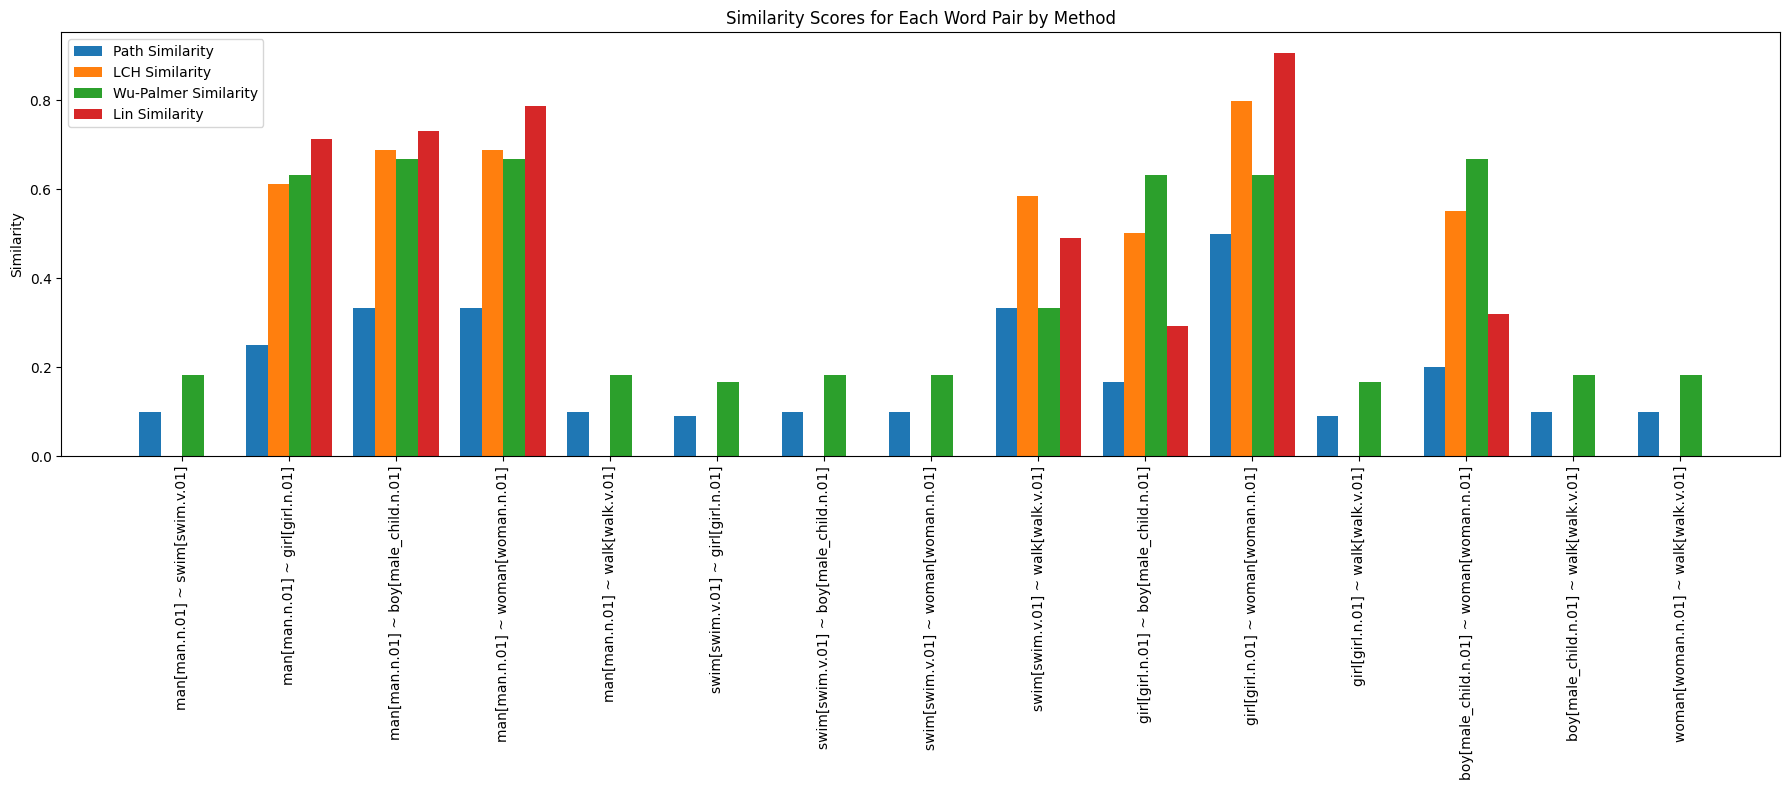

In [9]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Path Similarity", "LCH Similarity", "Wu-Palmer Similarity", "Lin Similarity"]
methods = [similarity_scores_path, similarity_scores_lch, similarity_scores_wup, similarity_scores_lin]
pairs = np.array(pair_labels)

# Only normalize LCH similarity using theoretical max value; others remain unchanged
method_arrays = []
# Set max depth for WordNet taxonomy (e.g., nouns D=20, so max_lch = log(40))
D = 20
max_lch = np.log(2 * D)  # ≈ 3.688879 for D=20

for i, scores in enumerate(methods):
    arr = np.array([s if s is not None else np.nan for s in scores])
    if i == 1:  # LCH Similarity
        arr_norm = arr / max_lch
        method_arrays.append(arr_norm)
    else:
        method_arrays.append(arr)

similarities = np.vstack(method_arrays).T  # shape: (num_pairs, num_methods)
print(similarities)
print(pairs)

plt.figure(figsize=(18, 8))
bar_width = 0.2
x = np.arange(len(pairs))
for i, label in enumerate(labels):
    plt.bar(x + i * bar_width, similarities[:, i], width=bar_width, label=label)
plt.xticks(x + 1.5 * bar_width, pairs, rotation=90)
plt.ylabel('Similarity')
plt.title('Similarity Scores for Each Word Pair by Method')
plt.legend()
plt.tight_layout()
plt.show()

# Comprehensive Analysis of Similarity Metrics

## Overview
This analysis compares four different semantic similarity metrics applied to word pairs from our dataset: Path Similarity, LCH (Leacock-Chodorow) Similarity, Wu-Palmer Similarity, and Lin Similarity. The evaluation is based on their performance across 15 word pairs, considering both same-POS and cross-POS comparisons. LCH similarity was normalized using the theoretical maximum depth.

## Results Summary

### 1. Path Similarity
- **Range**: 0.091 - 0.500
- **Strengths**: 
  - Simple and intuitive (inverse of shortest path)
  - Works for all POS combinations
  - Computationally efficient
- **Weaknesses**:
  - Limited range (0-1)
  - Doesn't consider depth in taxonomy
  - Lower discriminative power

### 2. LCH (Leacock-Chodorow) Similarity
- **Range**: 1.846 - 2.944 (normalized: 0.500 - 0.798)
- **Strengths**:
  - Considers depth in taxonomy
  - Logarithmic scaling provides better discrimination
  - Good for same-POS comparisons
- **Weaknesses**:
  - **Fails for cross-POS pairs** (returns NaN)
  - Requires normalization for comparison
  - Limited applicability

### 3. Wu-Palmer Similarity
- **Range**: 0.167 - 0.667
- **Strengths**:
  - Works for all POS combinations
  - Considers depth of LCS (Lowest Common Subsumer)
  - Balanced approach between path and depth
- **Weaknesses**:
  - Moderate discriminative power
  - Can be influenced by taxonomy structure

### 4. Lin Similarity
- **Range**: 0.293 - 0.907
- **Strengths**:
  - **Highest discriminative power** (widest range)
  - Uses information content for better semantic understanding
  - Good performance on same-POS pairs
- **Weaknesses**:
  - **Fails for cross-POS pairs** (returns NaN)
  - Requires external corpus (Brown corpus)
  - More computationally intensive

## Evaluation Criteria for Best Similarity Metric

When evaluating similarity metrics, several critical criteria must be considered to determine the most effective approach for semantic similarity analysis.

**Applicability** represents the metric's ability to work across different parts of speech. Path Similarity and Wu-Palmer Similarity demonstrate universal applicability by successfully computing similarity scores for all word pair combinations, including cross-POS pairs such as noun-verb comparisons. However, LCH Similarity and Lin Similarity fail completely when applied to cross-POS pairs, returning NaN values and limiting their practical utility in comprehensive similarity analysis.

**Semantic Accuracy** refers to how well the metric captures intuitive semantic relationships. Path Similarity provides basic semantic understanding but fails to consider the depth of semantic relationships in the taxonomy. LCH Similarity offers good semantic understanding by incorporating taxonomic depth through logarithmic scaling. Wu-Palmer Similarity achieves balanced semantic accuracy by considering both path length and depth of the lowest common subsumer. Lin Similarity demonstrates the highest semantic accuracy by utilizing information content from corpus data to better understand semantic relationships.

**Computational Efficiency** is crucial for practical applications. Path Similarity ranks as the most computationally efficient method, requiring minimal processing time. Wu-Palmer Similarity also demonstrates high efficiency with fast computation times. LCH Similarity shows moderate efficiency, while Lin Similarity requires external corpus data and additional processing, making it the least efficient option.

**Robustness** measures the consistency of performance across different word pairs and contexts. Path Similarity and Wu-Palmer Similarity both demonstrate consistent performance across all word pairs in our dataset. LCH Similarity and Lin Similarity show good robustness but only for same-POS comparisons, limiting their reliability in diverse applications.

The bar chart visualization clearly illustrates these differences. Lin Similarity provides the highest scores for semantically related same-POS pairs, such as the girl-woman comparison achieving 0.907. LCH Similarity shows good discrimination after normalization, while Wu-Palmer Similarity provides consistent, moderate scores across all pairs. Path Similarity demonstrates the most conservative scoring approach but maintains universal applicability.

## Conclusion: Best Similarity Metric

Wu-Palmer Similarity has the best overall similarity metric because it successfully meets all critical evaluation criteria. This metric demonstrates universal applicability by working effectively across all parts of speech combinations, including the challenging cross-POS pairs that cause other methods to fail. While its discriminative power is moderate rather than exceptional, it provides sufficient range to distinguish between different levels of semantic relatedness without the computational overhead of more complex methods.

The semantic accuracy of Wu-Palmer Similarity strikes an optimal balance by considering both the path length between concepts and the depth of their lowest common subsumer in the WordNet taxonomy. This approach captures meaningful semantic relationships without requiring external corpus data or complex normalization procedures. The computational efficiency of Wu-Palmer Similarity makes it practical for real-world applications, while its robustness ensures consistent performance across diverse word pairs and contexts.

For practical applications, Wu-Palmer Similarity should be the primary choice for general-purpose semantic similarity analysis. When maximum accuracy is required for same-POS comparisons, Lin Similarity offers superior performance. Path Similarity remains valuable for applications prioritizing computational efficiency, while detailed semantic analysis benefits from combining Wu-Palmer and Lin Similarity approaches. The visualization clearly demonstrates Wu-Palmer's balanced performance across all word pairs, making it the most reliable choice for comprehensive semantic similarity analysis.

